In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [167]:
import matplotlib.pyplot as plt

In [16]:
import time

In [2]:
with open('data_theta_profile.pkl', 'rb') as f:
    profile =  pickle.load(f)
with open('data_inversion_label.pkl', 'rb') as f:
    label =  pickle.load(f)

In [3]:
x_train, x_test, y_train, y_test = train_test_split(profile, label, test_size=0.25, random_state=69)

In [4]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [31]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(x_train), 
                       torch.FloatTensor(y_train))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TrainData(torch.FloatTensor(x_test), 
                       torch.FloatTensor(y_test))

In [110]:
train_loader = DataLoader(dataset=train_data, batch_size=64)
test_loader = DataLoader(dataset=test_data, batch_size=64)

In [55]:
# 定義類神經網路模型
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # 建立類神經網路各層
        self.flatten = nn.Flatten()  # 轉為一維向量
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(27, 64),   # 線性轉換
            #nn.ReLU(),               # ReLU 轉換
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # 定義資料如何通過類神經網路各層
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [129]:
# 定義類神經網路模型
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 建立類神經網路各層
        self.layer_1 = nn.Linear(27, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
    def forward(self, inputs):
        # 定義資料如何通過類神經網路各層
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

In [130]:
# 若 CUDA 環境可用，則使用 GPU 計算，否則使用 CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [131]:
# 建立類神經網路模型，並放置於 GPU 或 CPU 上
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=27, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [132]:
# 損失函數
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCEWithLogitsLoss()
# 學習優化器
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [133]:
# 訓練模型
def train(dataloader, model, loss_fn, optimizer):
    # 資料總筆數
    size = len(dataloader.dataset)
    #num_batches = len(dataloader)
    # 將模型設定為訓練模式
    model.train()
    #train_loss = 0
    # 批次讀取資料進行訓練
    for batch, (X, y) in enumerate(dataloader):
        # 將資料放置於 GPU 或 CPU
        X, y = X.to(device), y.to(device)

        pred = model(X)         # 計算預測值
        loss = loss_fn(pred, y.unsqueeze(1)) # 計算損失值（loss）
        #train_loss += loss_fn(pred, y).item()
        optimizer.zero_grad()   # 重設參數梯度（gradient）
        loss.backward()         # 反向傳播（backpropagation）
        optimizer.step()        # 更新參數
    #train_loss /= num_batches
    #return(train_loss)

In [134]:
# 測試模型
def test(dataloader, model, loss_fn):
    # 資料總筆數
    size = len(dataloader.dataset)

    # 批次數量
    num_batches = len(dataloader)

    # 將模型設定為驗證模式
    model.eval()

    # 初始化數值
    test_loss, correct = 0, 0

    # 驗證模型準確度
    with torch.no_grad():  # 不要計算參數梯度
        for X, y in dataloader:
            # 將資料放置於 GPU 或 CPU
            X, y = X.to(device), y.to(device)

            # 計算預測值
            pred = model(X)

            # 計算損失值的加總值
            test_loss += loss_fn(pred, y.unsqueeze(1)).item()

            # 計算預測正確數量的加總值
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct += binary_acc(pred, y.unsqueeze(1)).type(torch.float).sum().item()

    # 計算平均損失值與正確率
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss , correct*100

In [135]:
# 設定 epochs 數
epochs = 20
st_time = time.time()
total_trainloss = np.zeros((epochs)) 
total_testloss = np.zeros((epochs)) 
total_acc = np.zeros((epochs)) 
# 開始訓練模型
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    trainloss,acc1 = test(train_loader, model, loss_fn)
    testloss,acc = test(test_loader, model, loss_fn)
    total_trainloss[t] = trainloss
    total_testloss[t] = testloss
    total_acc[t] = acc
cost_time = time.time() - st_time
print('Total time use',cost_time)
#acc_diff = total_acc[29] - 80.6
#trainloss_diff = total_trainloss[29] - 0.5264
#testloss_diff = total_testloss[29] - 0.5513
#time_diff = cost_time - 486.8
#print('acc diff',acc_diff)
#print('train loss diff',trainloss_diff)
#print('test loss diff',testloss_diff )
#print('time diff',time_diff)
#print('done')

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 76.3%, Avg loss: 0.499320 

Test Error: 
 Accuracy: 74.4%, Avg loss: 0.512948 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.464837 

Test Error: 
 Accuracy: 75.2%, Avg loss: 0.484213 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.454061 

Test Error: 
 Accuracy: 74.8%, Avg loss: 0.477643 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.446666 

Test Error: 
 Accuracy: 75.1%, Avg loss: 0.471553 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.441100 

Test Error: 
 Accuracy: 75.9%, Avg loss: 0.472149 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.434042 

Test Error: 
 Accuracy: 75.6%, Avg loss: 0.471089 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.431693 

Test Error: 
 Accuracy: 75.7%, Avg loss: 0.4

In [88]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum#/y_test.shape[0]
    #acc = torch.round(acc * 100)
    
    return acc

In [156]:
for i in range(17,20):
    x, y = test_data[i:i+1][0], test_data[i][1]
    print(x)
    print(x_test[i])

tensor([[-0.6382, -1.6860, -0.9062, -1.3966, -1.1496, -0.7331, -0.2821, -0.2824,
         -0.1456, -0.2108, -0.1280, -0.0105,  0.1328,  0.2112,  0.3284,  0.5035,
          0.7315,  0.7103,  0.6998,  0.5339,  0.0188,  0.1552,  0.2853,  0.3532,
          0.3723,  0.4048,  0.4231]])
[-0.63824019 -1.68603765 -0.90615713 -1.39662458 -1.1495526  -0.73314493
 -0.28214438 -0.28244995 -0.14560434 -0.21077569 -0.12803946 -0.01049908
  0.13276832  0.21118404  0.32837976  0.50350569  0.73154825  0.71034984
  0.69982336  0.53391964  0.01878556  0.15522556  0.28528395  0.35319186
  0.3723      0.40475259  0.42314673]
tensor([[-1.1611, -1.4485, -0.7113, -0.7416,  0.0897,  0.7169,  0.4058, -0.1712,
         -0.0226,  0.0573,  0.2148,  0.4485, -0.2809, -0.3020, -0.0382,  0.2507,
          0.4464,  0.4292,  0.4049,  0.4671,  0.7125,  0.2183, -0.5469, -0.4369,
         -0.2897, -0.2016, -0.1823]])
[-1.16113489 -1.44848902 -0.71125109 -0.7415677   0.08972832  0.71693721
  0.40578785 -0.17121238 -0.0226438

In [151]:
x,y = test_data[i:i+5][0], test_data[i][1]

In [152]:
print(x)

tensor([[-0.5027,  0.6159,  0.6864,  0.6622,  0.6277, -0.2531, -0.5094, -0.5449,
         -0.1832,  0.3851,  0.9738,  1.3584,  1.6820,  1.7150,  1.1281,  0.7090,
          0.9053,  1.0756,  1.2418,  1.3878,  1.5194,  1.6426,  1.6830,  0.2723,
          0.0277,  0.0999,  0.1323]])


In [149]:
x,y = test_data[i][0], test_data[i][1]

In [150]:
print(x)

tensor([-0.5027,  0.6159,  0.6864,  0.6622,  0.6277, -0.2531, -0.5094, -0.5449,
        -0.1832,  0.3851,  0.9738,  1.3584,  1.6820,  1.7150,  1.1281,  0.7090,
         0.9053,  1.0756,  1.2418,  1.3878,  1.5194,  1.6426,  1.6830,  0.2723,
         0.0277,  0.0999,  0.1323])


In [157]:
model.eval()
pred_result = np.zeros((2355))
truth = np.zeros((2355))
for i in range(0,2355):
    x, y = test_data[i:i+1][0], test_data[i][1]
    pred = model(x)
    pred_result[i] = torch.round(torch.sigmoid(pred))
    truth[i] = y

In [158]:
print(pred_result[0:15])
print(truth[0:15])

[1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1.]


In [162]:
print(pred_result.shape,truth.shape)

(2355,) (2355,)


In [ ]:
print()

In [163]:
hist_pred = np.histogram2d(pred_result,truth,bins=2)

In [164]:
nparray_h = hist_pred[0]
for i in range(0,2):
    print(nparray_h[:,i])

[305. 366.]
[ 207. 1477.]


In [171]:
classes = ['no','have']

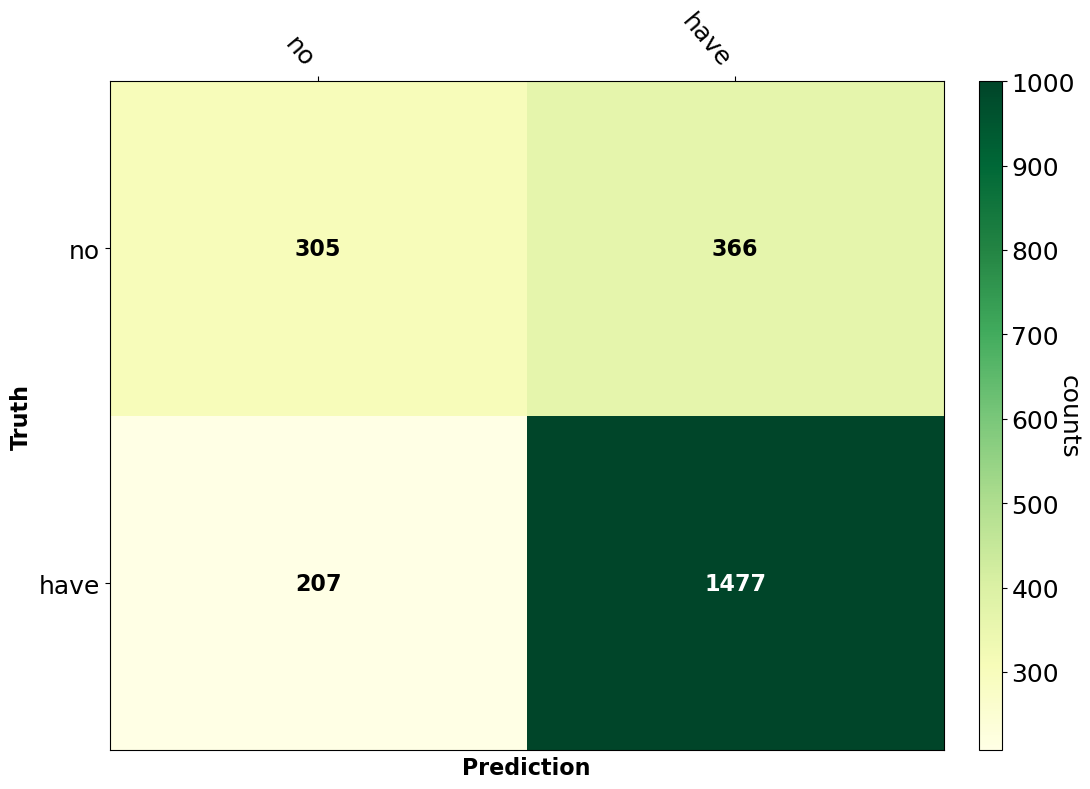

In [183]:
f,ax= plt.subplots(figsize=(11,8))
#ax.hist2d(pred_result, truth,bins=10,cmap='YlGn')
hitplot = ax.pcolormesh(nparray_h.T,cmap='YlGn',vmax=1000)
for xx in range(0,2):
  for yy in range(0,2):
    if nparray_h[xx,yy] > 500:
      ax.text(xx+0.5, yy+0.5, int(nparray_h[xx,yy]),color='w', size=16,fontweight='semibold',ha='center',va='center')
    else:
      ax.text(xx+0.5, yy+0.5, int(nparray_h[xx,yy]),color='k', size=16,fontweight='semibold',ha='center',va='center')
ax.invert_yaxis()
plt.ylabel('Truth',fontsize=16,fontweight='semibold',rotation=90)
plt.xlabel('Prediction',fontsize=16,fontweight='semibold')
plt.xticks(np.arange(0.5,2,1),classes,fontsize=18,rotation=310,horizontalalignment='right')
ax.xaxis.tick_top()
plt.yticks(np.arange(0.5,2,1),classes,fontsize=18)
cb = plt.colorbar(hitplot,aspect=30,fraction=0.03, pad=0.04)
cb.ax.tick_params(labelsize=18)
cb.set_label('counts', size=18,rotation=270)
plt.tight_layout()
#plt.savefig('hw_1_1_heatmap_pcolor'+ date_test  +'.png',dpi=400)